In [1]:
import json

import nltk
from nltk.corpus import stopwords
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
jsonl_files = [
    "output/20250312/topics_10k_ideology_comparison_20250312_010450.jsonl"
]

In [3]:
left_right = []

for file in jsonl_files:
    with open(file, "r") as f:
        for line in f:
            item = json.loads(line)
            if item["label"] == "unbiased":
                continue

            for bias in item["potential_bias"]:
                left_right.append({
                    "bias": bias["bias"],
                    "left": bias["left_wing_perspective"],
                    "right": bias["right_wing_perspective"]
                })


df = pd.DataFrame(left_right)
df

,bias,left,right
0,Politicization and Framing of the COVID-19 Lab...,Emphasizes scientific uncertainty and cautions...,Leans toward holding China accountable for the...
1,Leadership Criticism and Framing of Disaster R...,Left-leaning politicians and commentators migh...,Right-leaning voices could stress excessive re...
2,Nationalistic and bellicose rhetoric toward a ...,Left-leaning policymakers generally advocate f...,Right-leaning policymakers often emphasize str...
3,Framing of the Gaza ceasefire deal largely thr...,Many left-leaning US politicians and commentat...,Right-leaning voices generally support a stron...
4,Politically motivated framing that presents th...,Left-leaning figures and organizations (such a...,Right-wing voices praise the move as a correct...
...,...,...,...
1627,Framing of federal work policies as a tool for...,Many liberal policymakers and union leaders su...,Conservative figures and Trump supporters argu...
1628,Disparaging traditional media while extolling ...,Many on the left view independent media with c...,Right-leaning commentators bolster independent...
1629,The article heavily criticizes the Biden admin...,Left-wing policymakers in the 2020s tend to em...,Right-wing figures and conservative groups hav...
1630,Sensationalism and Framing Bias,Left-wing politicians (like those aligned with...,"Right-wing voices might seize on the vivid, em..."


In [63]:
vis_series = df["right"].str.replace("necessary", "**necessary**")

In [64]:
for line in vis_series[df["right"].str.contains("necessary")]:
    print(line)
    print()

Right-leaning policymakers often emphasize strong national sovereignty, assertive foreign policy, and protection of national economic interests. They may support the idea that U.S. exceptionalism and robust negotiation tactics—if backed by national strength—are **necessary** to safeguard American interests abroad.

Proponents argue that relieving bloated governmental structures can lead to a leaner, more efficient government, viewing the criticism as overblown resistance to **necessary** reform.

On the other hand, right-wing voices often defend austerity as a **necessary** step to ensure fiscal discipline and long-term economic stability, contending that such tough measures are essential to restore market confidence.

Right-wing policymakers are more likely to support national sovereignty and view multilateral institutions like the ICC as overreaching or politically motivated, defending unilateral actions as **necessary** for national interest.

Right-wing leaders often defended stron

In [36]:
# Remove left, lean, leaning, wing from the left and right columns
stopwords_cloud = stopwords.words('english') + ["ing", "u", "s", "may", "would"]

df["left_cloud"] = df["left"].str.replace(r"Left|left|leaning|wing|commentators|policies|politicians|argue|arguing|emphasize|Many|might|view|measure|criticize|often|figure|voice|2020s", "", regex=True)
df["right_cloud"] = df["right"].str.replace(r"Right|right|leaning|wing|commentators|policies|politicians|argue|arguing|emphasize|Many|might|view|figure|measure|criticize|often|figure|voice|2020s", "", regex=True)

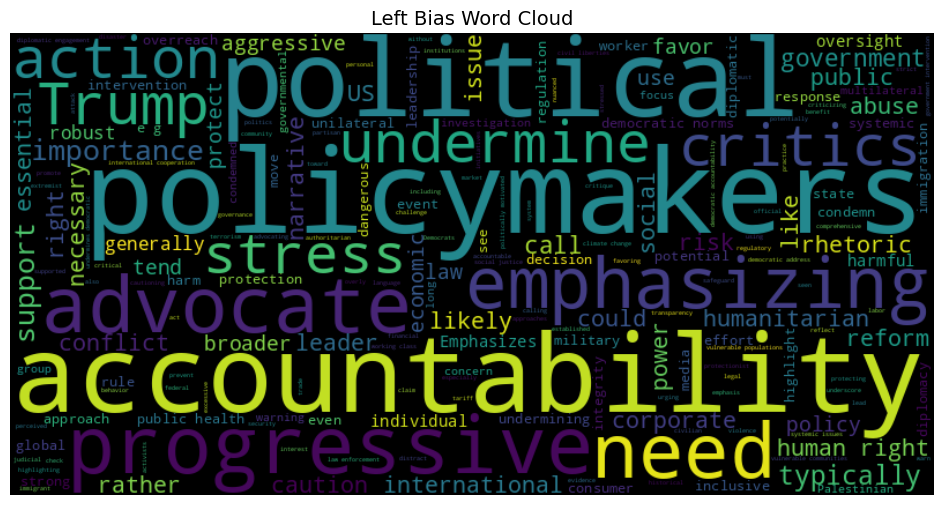

In [37]:
text_left = ' '.join(df['left_cloud'])
wordcloud_left = WordCloud(width=800, height=400, stopwords=stopwords_cloud).generate(text_left)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_left, interpolation='bilinear')
plt.axis('off')
plt.title('Left Bias Word Cloud')
plt.show()

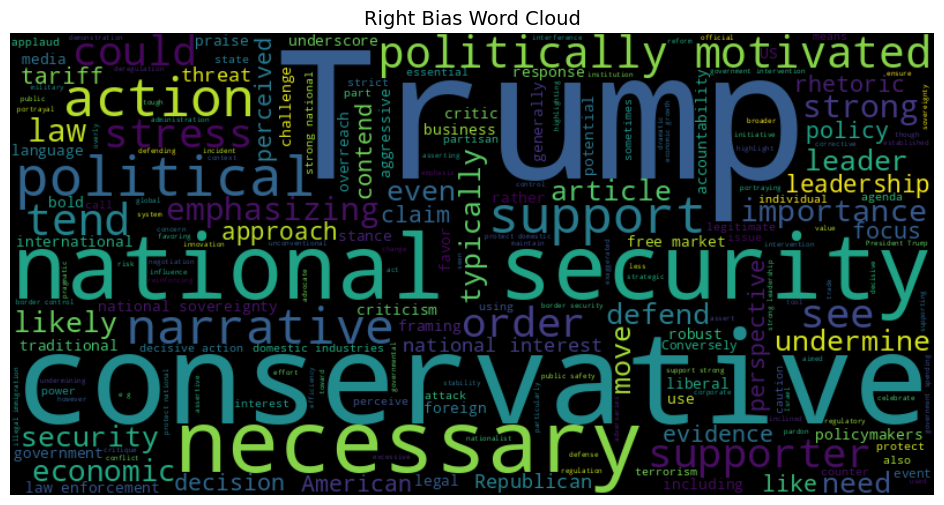

In [38]:
text_right = ' '.join(df['right_cloud'])
wordcloud_right = WordCloud(width=800, height=400, stopwords=stopwords_cloud).generate(text_right)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_right, interpolation='bilinear')
plt.axis('off')
plt.title('Right Bias Word Cloud')
plt.show()

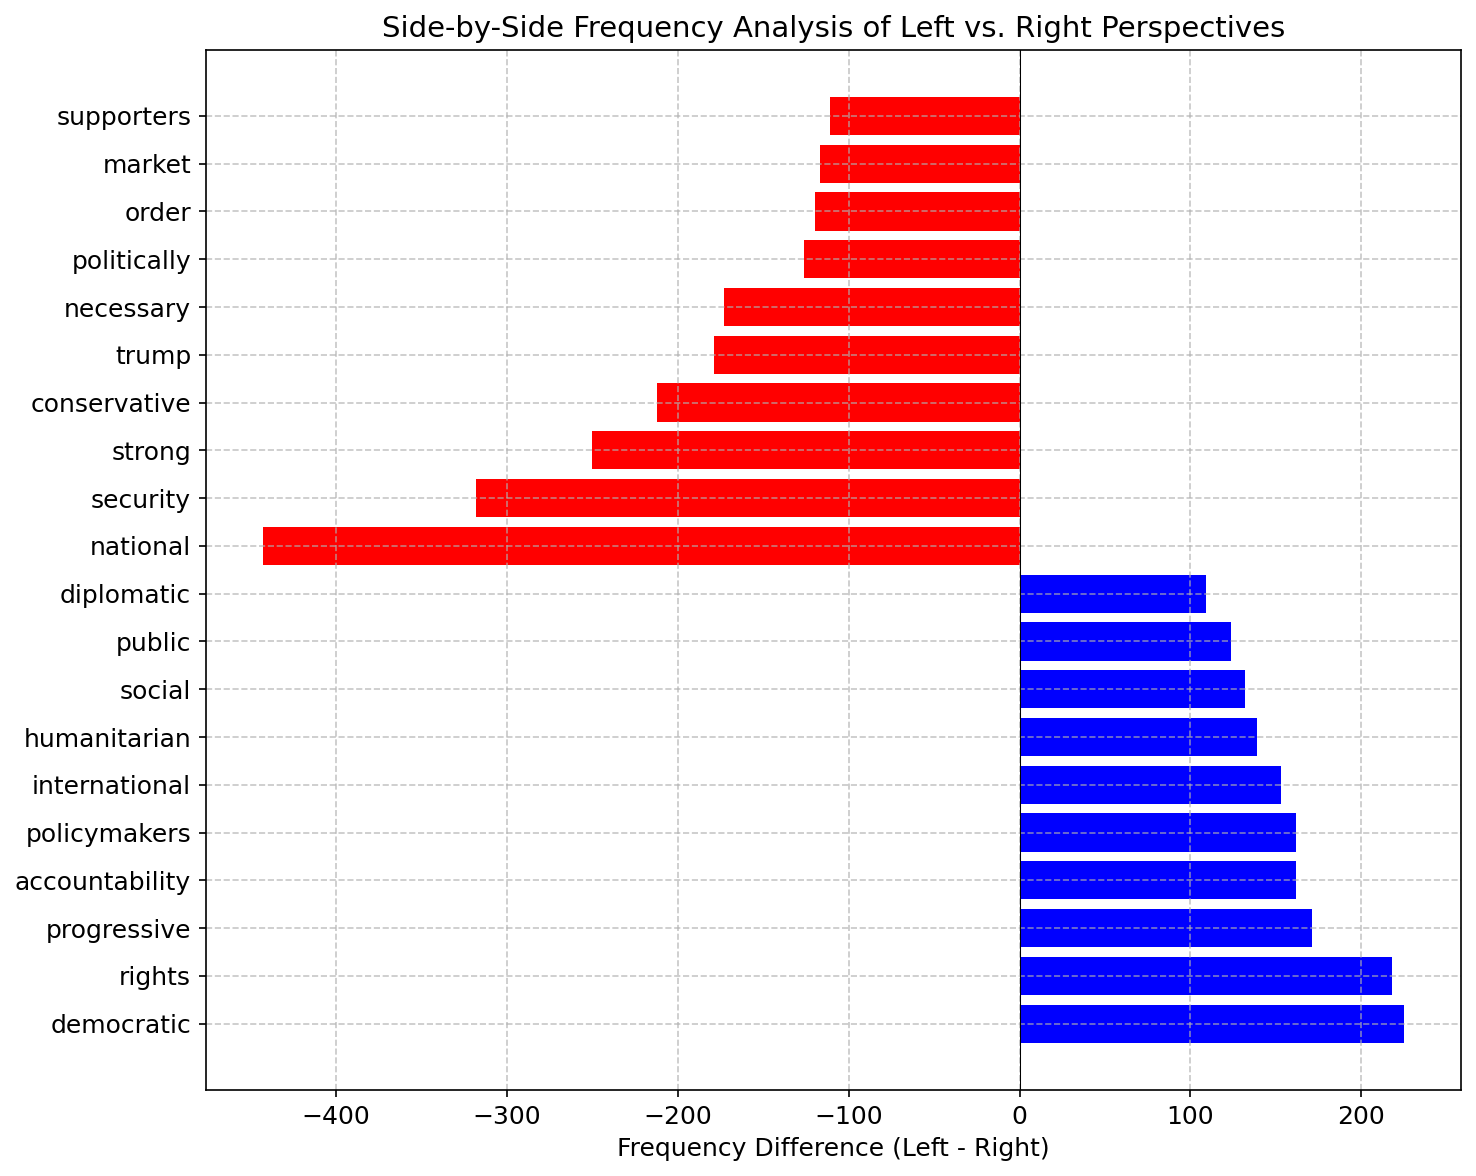

In [39]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

plt.rcParams['font.family'] = 'Dejavu Sans'  # Change to your preferred font
plt.rcParams['font.size'] = 12  # Adjust size
plt.rcParams['axes.titlesize'] = 14  # Title size
plt.rcParams['axes.labelsize'] = 12  # Label size

# Combine text for left and right
left_text = ' '.join(df['left_cloud'])
right_text = ' '.join(df['right_cloud'])

# Vectorize text
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform([left_text, right_text])
words = vectorizer.get_feature_names_out()

# Compute frequencies
left_freq = vectors.toarray()[0]
right_freq = vectors.toarray()[1]

freq_df = pd.DataFrame({'word': words, 'left_freq': left_freq, 'right_freq': right_freq})
freq_df['diff'] = freq_df['left_freq'] - freq_df['right_freq']

# Select top words associated with each side
top_left = freq_df.sort_values(by='diff', ascending=False).head(10)
top_right = freq_df.sort_values(by='diff').head(10)

# Combine for plotting
combined_freq = pd.concat([top_left, top_right])

# Plot diverging bar chart
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
colors = ['blue' if x > 0 else 'red' for x in combined_freq['diff']]
ax.barh(combined_freq['word'], combined_freq['diff'], color=colors)
ax.set_xlabel('Frequency Difference (Left - Right)')
ax.set_title('Side-by-Side Frequency Analysis of Left vs. Right Perspectives')

plt.axvline(0, color='black', linewidth=0.5)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


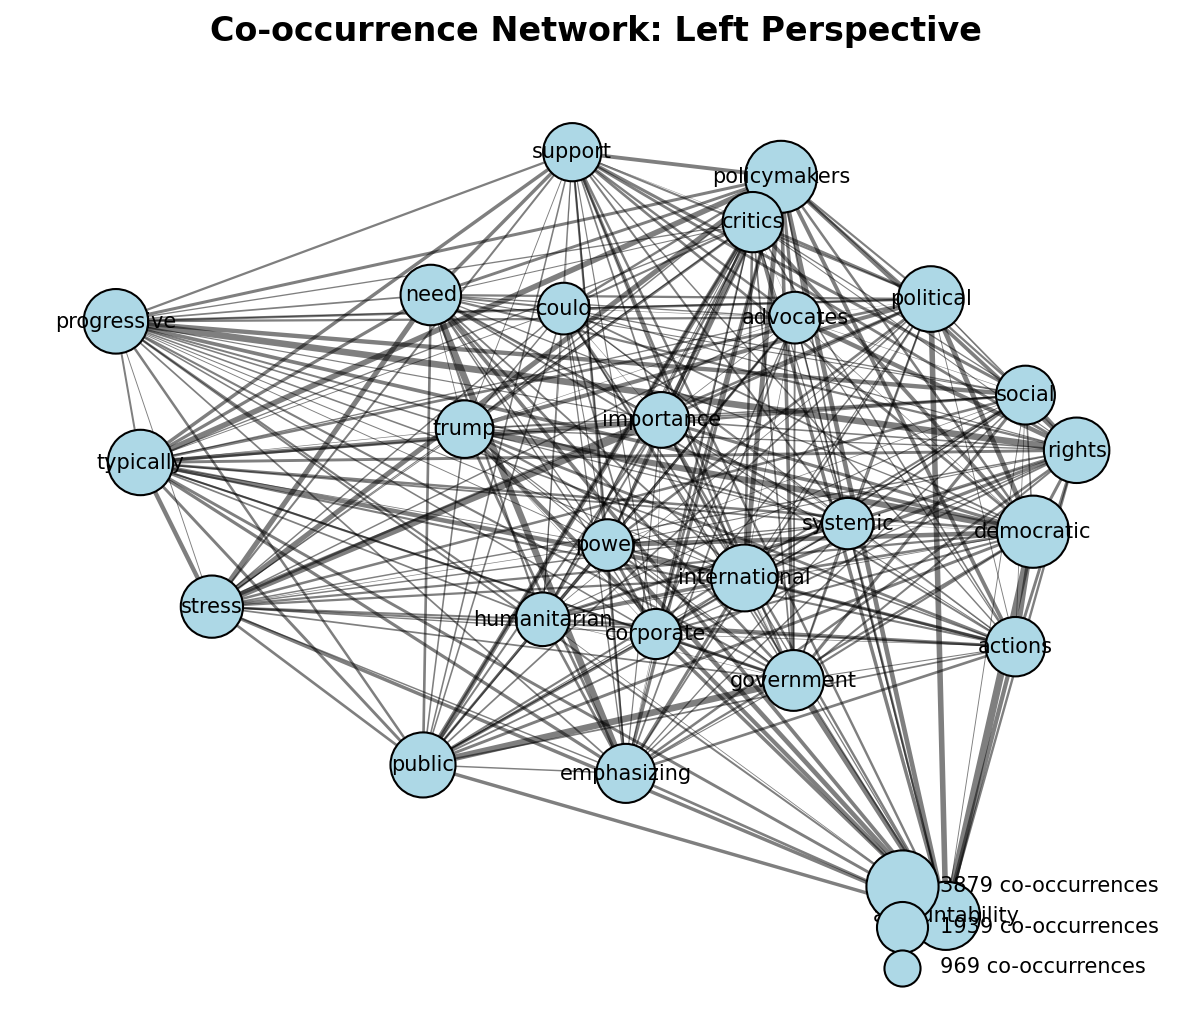

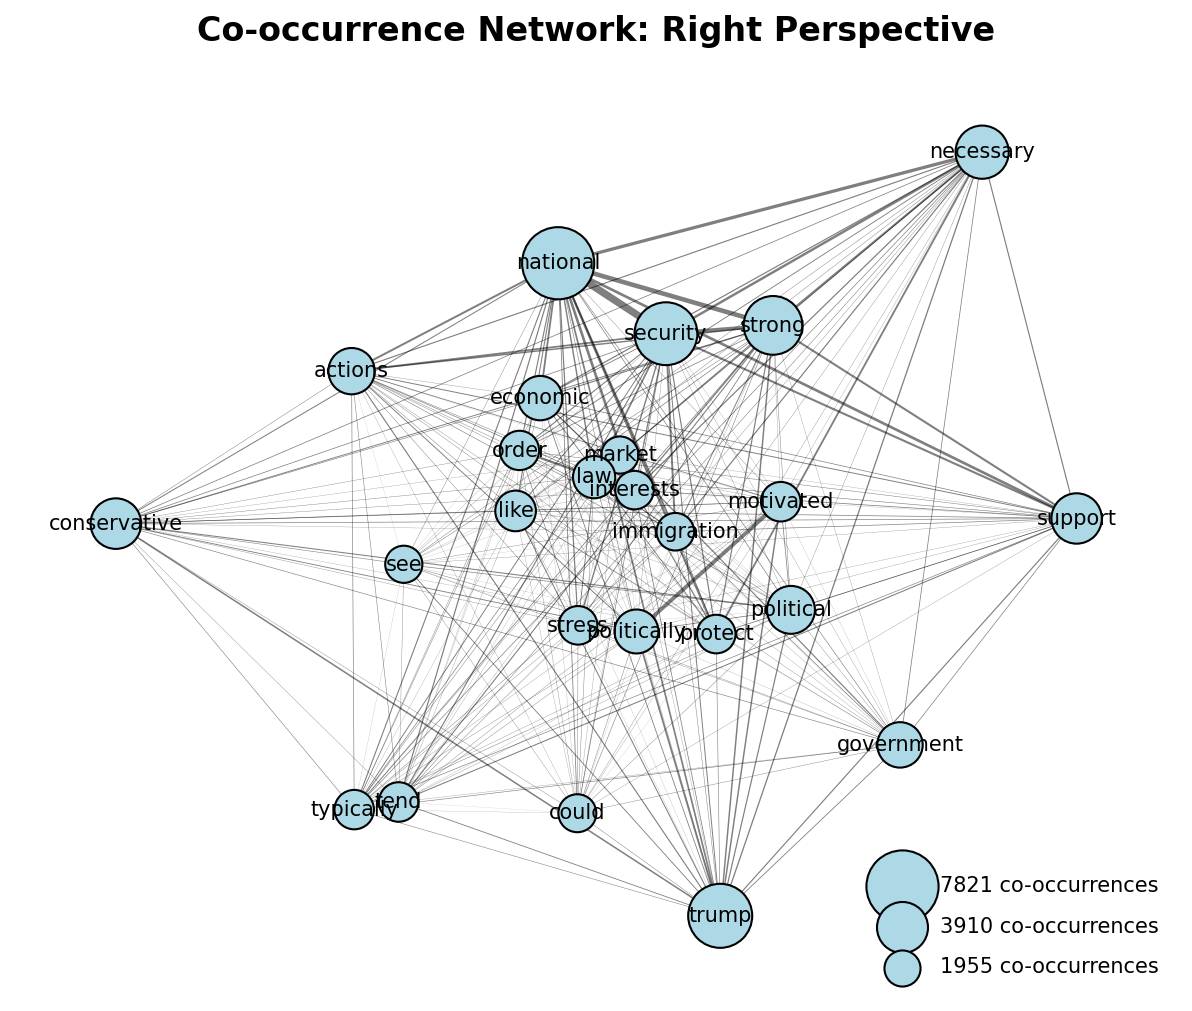

In [45]:
# Function to extract co-occurrence pairs from text and create a weighted graph
def get_cooccurrence(texts):
    vectorizer = TfidfVectorizer(stop_words=stopwords_cloud, ngram_range=(1, 1))
    X = vectorizer.fit_transform(texts)
    words = vectorizer.get_feature_names_out()

    cooccurrence_graph = nx.Graph()
    
    # Iterate through each document and create co-occurrence relationships
    for i in range(X.shape[0]):
        word_indices = X[i].nonzero()[1]
        word_list = [words[idx] for idx in word_indices]
        for pair in combinations(word_list, 2):
            if cooccurrence_graph.has_edge(*pair):
                cooccurrence_graph[pair[0]][pair[1]]['weight'] += 1
            else:
                cooccurrence_graph.add_edge(pair[0], pair[1], weight=1)
    
    return cooccurrence_graph

# Function to filter the network and retain only the most important nodes (top connected words)
def filter_graph_by_weight(graph, top_n=20):
    """ Filters the network graph to retain only the top N nodes with the highest total edge weights. """
    edge_weight_sums = {node: sum(weight for _, _, weight in graph.edges(node, data='weight')) for node in graph.nodes()}
    top_nodes = sorted(edge_weight_sums, key=edge_weight_sums.get, reverse=True)[:top_n]
    filtered_graph = graph.subgraph(top_nodes).copy()  # Create a new subgraph
    
    return filtered_graph, edge_weight_sums

# Function to plot a network graph with node size based on total edge weight
def plot_filtered_graph_weighted(graph, edge_weight_sums, title, max_edge_width=3.5, max_node_size=1200):
    plt.figure(figsize=(10, 8), dpi=150)
    pos = nx.kamada_kawai_layout(graph)  # Layout for better spacing

    # Get node total edge weights and normalize sizes
    node_weights = {node: edge_weight_sums[node] for node in graph.nodes()}
    max_weight = max(node_weights.values()) if node_weights else 1
    node_sizes = [max_node_size * (node_weights[node] / max_weight) for node in graph.nodes()]

    # Get edge weights and normalize
    edges, weights = zip(*nx.get_edge_attributes(graph, 'weight').items()) if graph.edges else ([], [])
    max_edge_weight = max(weights) if weights else 1
    scaled_weights = [max_edge_width * (w / max_edge_weight) for w in weights]

    # Draw nodes with varying sizes
    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color='lightblue', edgecolors='black')
    nx.draw_networkx_edges(graph, pos, edgelist=edges, width=scaled_weights, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_family='sans-serif')

    # Create legend for node sizes
    legend_sizes = [max_node_size * (w / max_weight) for w in [max_weight, max_weight / 2, max_weight / 4]]
    legend_labels = [f"{int(w)} co-occurrences" for w in [max_weight, max_weight / 2, max_weight / 4]]

    for size, label in zip(legend_sizes, legend_labels):
        plt.scatter([], [], s=size, c='lightblue', edgecolors='black', label=label)

    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, fontsize=10, loc='lower left')

    # Title and aesthetics
    plt.title(title, fontsize=16, fontweight='bold', pad=15)
    plt.axis('off')
    plt.show()


# Construct co-occurrence networks for left and right texts
left_graph = get_cooccurrence(df['left_cloud'])
right_graph = get_cooccurrence(df['right_cloud'])

# Filter both graphs based on total edge weights
filtered_left_graph, left_weights = filter_graph_by_weight(left_graph, top_n=25)
filtered_right_graph, right_weights = filter_graph_by_weight(right_graph, top_n=25)

# Plot the refined networks with node sizes based on total edge weight
plot_filtered_graph_weighted(filtered_left_graph, left_weights, "Co-occurrence Network: Left Perspective")
plot_filtered_graph_weighted(filtered_right_graph, right_weights, "Co-occurrence Network: Right Perspective")


## RAG

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("Alibaba-NLP/gte-Qwen2-1.5B-instruct", trust_remote_code=True)
# In case you want to reduce the maximum length:
model.max_seq_length = 8192

queries = [
    "how much protein should a female eat",
    "summit define",
]
documents = [
    "As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
    "Definition of summit for English Language Learners. : 1  the highest point of a mountain : the top of a mountain. : 2  the highest level. : 3  a meeting or series of meetings between the leaders of two or more governments.",
]

query_embeddings = model.encode(queries, prompt_name="query")
document_embeddings = model.encode(documents)

scores = (query_embeddings @ document_embeddings.T) * 100
print(scores.tolist())

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-12 18:06:29.247974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741802789.256254   74601 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741802789.259920   74601 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/gte-Qwen2-1.5B-instruct:
- modeling_qwen.py
. Make sure to double-check they do not contain

[[78.49688720703125, 17.04286766052246], [14.9245023727417, 75.37960815429688]]


In [7]:
df_queries = pd.read_csv("queries/policy_queries.csv")

In [20]:
query_embeddings = model.encode(df_queries["query"].to_list())

In [10]:
left_embeddings = model.encode(df["left"].to_list())
right_embeddings = model.encode(df["right"].to_list())

In [12]:
left_scores = (query_embeddings @ left_embeddings.T)
right_scores = (query_embeddings @ right_embeddings.T)

In [29]:
def get_relevant_documents(model, queries, query_embeddings, documents, document_embeddings, threshold=.5):
    """
    Retrieve all relevant documents based on a similarity score threshold.
    
    Parameters:
        model (SentenceTransformer): The embedding model.
        queries (list of str): List of query texts.
        documents (list of str): List of document texts.
        threshold (float): Minimum similarity score to consider a document relevant.
    
    Returns:
        dict: A dictionary where each query maps to a list of relevant documents.
    """
    scores = (query_embeddings @ document_embeddings.T)
    
    relevant_docs = {}
    for i, query in enumerate(queries):
        relevant_docs[query] = [documents[j] for j in range(len(documents)) if scores[i, j] >= threshold]
    
    return relevant_docs

In [66]:
domains = df_queries["domain"].to_list()


left_mappings = get_relevant_documents(model, domains, query_embeddings, df["left"].to_list(), left_embeddings, threshold=.5)
right_mappings = get_relevant_documents(model, domains, query_embeddings, df["right"].to_list(), right_embeddings, threshold=.5)

In [77]:
df_gt = pd.read_csv("ground_truth_framework.csv")

In [90]:
import numpy as np

def wrap_query(text):
    return f"Retrieve the supporting document for this view: {text}"

res = []

for domain in domains:
    domain_res = {"domain": domain}
    
    gt = df_gt[df_gt["domain"] == domain].iloc[0]
    gt_left = gt["left_philosophy"] + " " + gt["left_arguments"]
    gt_right = gt["right_philosophy"] + " " + gt["right_arguments"]
    
    left_encodings = model.encode([wrap_query(text) for text in left_mappings[domain]])
    gt_left_encoding = model.encode(gt_left)
    left_similarities = left_encodings @ gt_left_encoding.T if left_encodings.size > 0 else np.array([0.0])
    
    right_encodings = model.encode([wrap_query(text) for text in right_mappings[domain]])
    gt_right_encoding = model.encode(gt_right)
    right_similarities = right_encodings @ gt_right_encoding.T if right_encodings.size > 0 else np.array([0.0])
    
    domain_res["left_len"] = len(left_mappings[domain])
    domain_res["left_alignment_mean"] = np.mean(left_similarities) if left_similarities.size > 0 else 0.0
    
    domain_res["right_len"] = len(right_mappings[domain])
    domain_res["right_alignment_mean"] = np.mean(right_similarities) if right_similarities.size > 0 else 0.0
    
    res.append(domain_res)

df_alignment = pd.DataFrame(res)


In [91]:
df_alignment

,domain,left_len,left_alignment_mean,right_len,right_alignment_mean
0,Abortion and Reproductive Rights,2,0.551681,3,0.585030
1,Gun Control vs. Gun Rights,10,0.646311,13,0.583106
2,Immigration Policy,67,0.648841,121,0.666322
3,Healthcare and the Role of Government,10,0.608348,1,0.576420
4,Climate Change and Energy Policy,27,0.624276,4,0.610328
5,LGBTQ+ Rights,45,0.652346,10,0.627882
6,Racial Justice and Policing,113,0.591790,62,0.594177
7,Education and Curriculum Battles,8,0.576340,21,0.565023
8,Voting Rights and Election Integrity,5,0.607240,7,0.597412
9,Technology Regulation and Free Speech,34,0.647434,13,0.671997


## Sentiment analysis

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon if not already installed
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df['left_sentiment'] = df['left'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
df['right_sentiment'] = df['right'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...


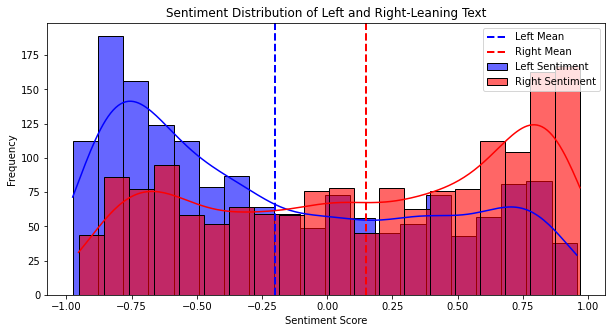

In [93]:
# Visualization
plt.figure(figsize=(10, 5))
sns.histplot(df['left_sentiment'], bins=20, kde=True, label="Left Sentiment", color='blue', alpha=0.6)
sns.histplot(df['right_sentiment'], bins=20, kde=True, label="Right Sentiment", color='red', alpha=0.6)

plt.axvline(df['left_sentiment'].mean(), color='blue', linestyle='dashed', linewidth=2, label="Left Mean")
plt.axvline(df['right_sentiment'].mean(), color='red', linestyle='dashed', linewidth=2, label="Right Mean")

plt.title("Sentiment Distribution of Left and Right-Leaning Text")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [167]:
import pandas as pd

In [168]:
df_human = pd.read_csv("labels.csv", index_col="id")
df_human

,label,comments
id,,
0,4.0,NaN
1,5.0,NaN
2,1.0,NaN
3,3.0,NaN
4,5.0,NaN
...,...,...
96,2.0,NaN
97,5.0,NaN
98,3.0,NaN


In [169]:
df_human = df_human.dropna(subset=["label"]).copy()
df_human["label"] = df_human["label"].astype(int)
df_human["label_5_class"] = df_human["label"]
df_human.loc[df_human["label_5_class"] == 5, "label_5_class"] = 2

In [170]:
df_deepseek = pd.read_csv("./data/topics_10k_deepseek_logits.csv", index_col=0)

In [171]:
df_merged = df_human.merge(df_deepseek, left_index=True, right_index=True, how="inner")

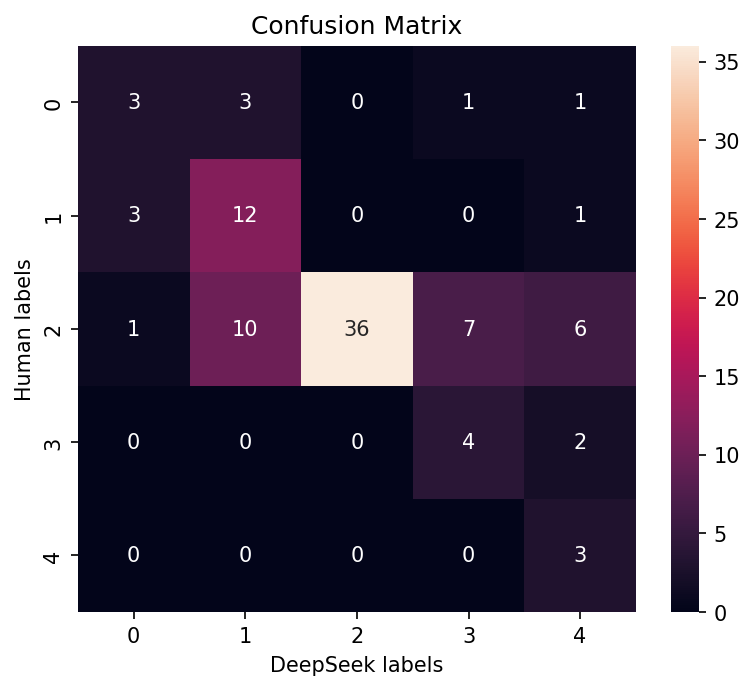

In [172]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6, 5), dpi=150)
cm = confusion_matrix(df_merged["label_5_class"], df_merged["label_y"])
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("DeepSeek labels")
plt.ylabel("Human labels")
plt.title("Confusion Matrix")
plt.show()

In [173]:
(df_merged["label_5_class"] == df_merged["label_y"]).mean()

0.6236559139784946

In [174]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(df_merged["label_5_class"], df_merged["label_y"])
print("Cohen's Kappa Score:", kappa_score)

Cohen's Kappa Score: 0.45035460992907805


In [177]:
import os
import csv
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# 1. Load the *base* LLaMA model for sequence classification
base_model_name = "meta-llama/Llama-3.2-1B"
tokenizer_name = "tokenizer"
access_token = os.environ.get("HF_TOKEN")

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    token=access_token,
    num_labels=5,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Set pad token
tokenizer.add_special_tokens({"pad_token":"[PAD]"})
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

# 2. Load the LoRA adapter on top of the base model
adapter_path = "../30100-final/llama/best_model/best_model_logits_e6"
model = PeftModel.from_pretrained(model, adapter_path)

# 3. Create the pipeline with the specified model and tokenizer
pipeline = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer
)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DiffLlamaForSequenceClassification', 'DistilBe

In [178]:
labels = pipeline((df_merged["article_title"] + " " + df_merged["article_text"]).to_list())

In [ ]:
for label in labels:
    